# Libraries

In [19]:
# Data manipulation
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt

# Model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Model Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Model Saving
import pickle

# Load Dataset

## Dataset CSV

In [9]:
df = pd.read_csv("retail_store_inventory_cleaned.csv")

## Dataset Filtering

In [10]:
df["date"] = pd.to_datetime(df["date"], errors='coerce') # handle datatype 

# Group Date from day to week
df = df.groupby(['store_id', 'product_id', pd.Grouper(key='date', freq='W-Mon')]).agg(
    units_sold_sum=('units_sold', 'sum'), # units sold is aggregated by summing
    price_mean=('price', 'mean') # price is aggregated by averaging
).reset_index().sort_values('date')

# Set Per-Store Data
store1=df[df["store_id"]=="S001"]
store2=df[df["store_id"]=="S002"]
store3=df[df["store_id"]=="S003"]
store4=df[df["store_id"]=="S004"]
store5=df[df["store_id"]=="S005"]

data=store1 # We only use 1 store for this model

# Filter to product 1
sp1 = data.groupby(['date','product_id']).sum()
sp1_filtered = sp1.loc[sp1.index.get_level_values('product_id') == 'P0001']
sp1_filtered_reset = sp1_filtered.reset_index(level='product_id', drop=True) # Drop the prodct id
unit = sp1_filtered_reset.reset_index() # safe the filtered data to variable named unit

/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_30015/1185783739.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sp1 = data.groupby(['date','product_id']).sum()


# Train Test Split

In [11]:
split_date = "2023-09-01" # Split date for train and test data
train = unit.loc[unit.date <= split_date].copy() # train data is taken <=2023=09=01
test = unit.loc[unit.date > split_date].copy() # test data is taken >2023=09=01

print('Train size : ', train.shape)
print('Test size : ', test.shape)

Train size :  (87, 3)
Test size :  (18, 3)


```
Train set = 87 weeks
Test set = 18 weeks
```

# Seasonal Decomposition

```
We perform seasonal decomposition to analyze the trend and seasonality of the dataset.
```

## Additive

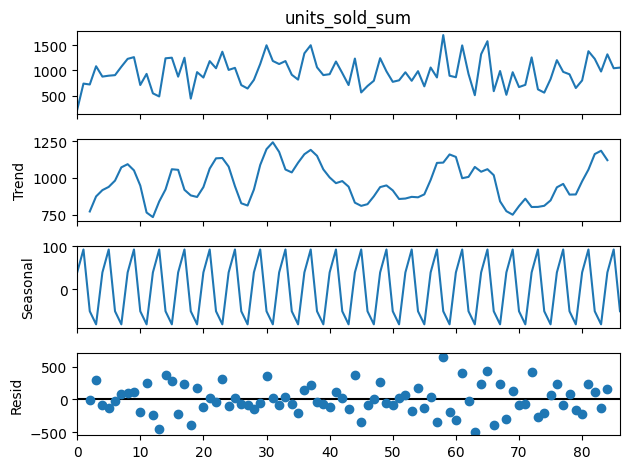

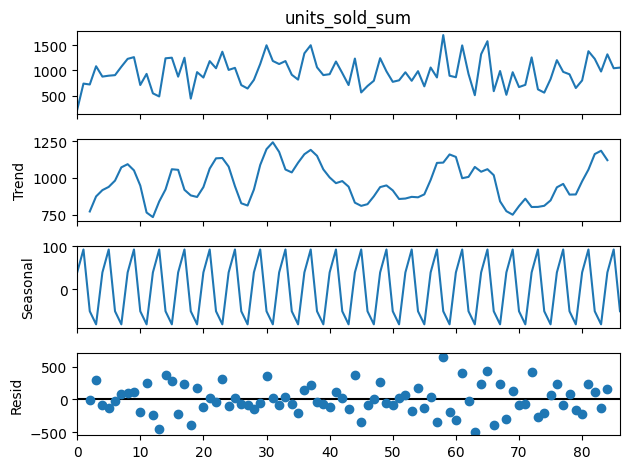

In [12]:
decomposition = seasonal_decompose(train['units_sold_sum'], model='additive', period=4)  # period=4 for monthly, adjust if needed
decomposition.plot()

```
As we can see, the additive model doesn't perform well. The residuals left by the model are quite high.
```

## Multiplicative

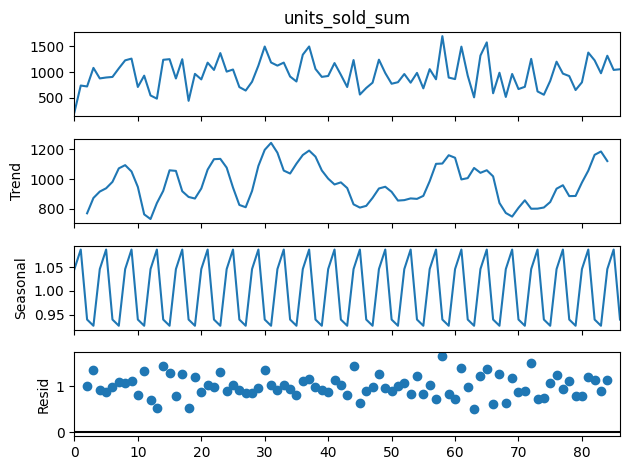

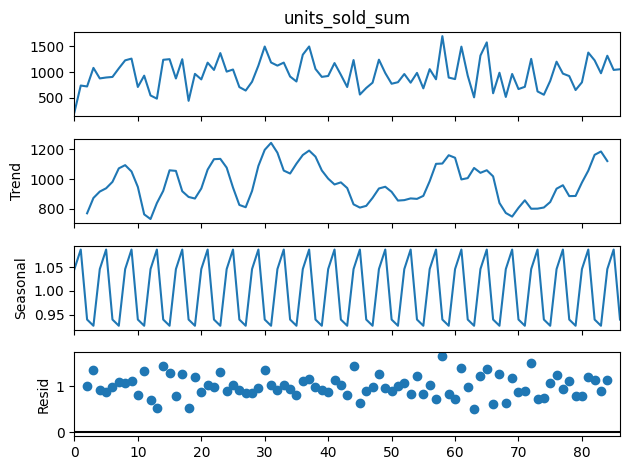

In [13]:
decomposition = seasonal_decompose(train['units_sold_sum'], model='multiplicative', period=4)  # period=4 for monthly, adjust if needed
decomposition.plot()

# ACF and PACF

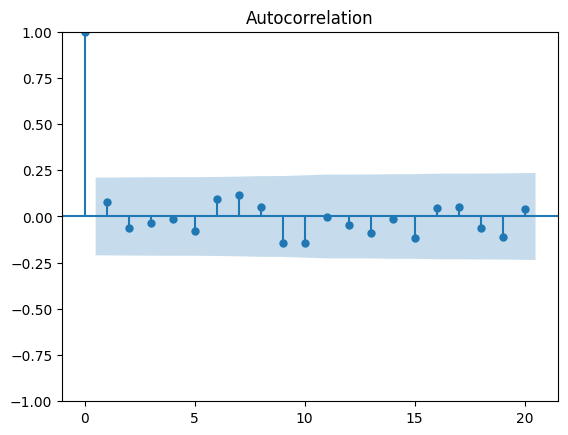

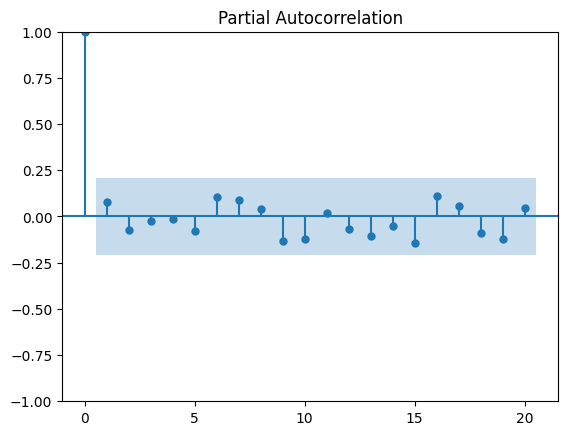

In [14]:
plot_acf(train['units_sold_sum'])
plot_pacf(train['units_sold_sum'])
plt.show()

```
ACF plot suggests that there is no significant autocorrelation in your time series data after lag 0.

PACF Plot
- The first lag (lag 1) has no significant spike beyond the confidence interval.
- The rest of the lags also do not show strong significance.
- This suggests that there is no strong AR (Auto-Regressive) pattern.

So for the p,d,q parameter :
p = 1
d = 0
q = 1
```

# Model Training

## SARIMAX + exogenus variables ('price')

```
We trained several time series models, including:

- ARIMA - ARIMA (AutoRegressive Integrated Moving Average) does not inherently handle seasonality well because it assumes a stationary time series.
** Bad model for this dataset

- SARIMAX
- Holt-Winters
- LSTM
- XGBoostRegressor
- FB Prophet
- FB Prophet + XGBoost
- SARIMAX + exogenous variables (regression)

** Other models can be found in the 'Other Models' folder.

We concluded that SARIMAX with exogenous variables is the best model to pursue our project goal.
```

In [16]:
# Define the exogenus variable as price
exog_vars = train[['price_mean']]

# Define the model SARIMAX with p=1, d=0, q=1, and seasonality 4 (monthly)
model_sar1 = SARIMAX(train['units_sold_sum'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 4),exog=exog_vars)

# Train the model
result_model_sar1 = model_sar1.fit()

# AIC
print('The AIC is ', result_model_sar1.aic)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.19309D+00    |proj g|=  3.81801D-02

At iterate    5    f=  7.18881D+00    |proj g|=  2.45620D-02

At iterate   10    f=  7.17668D+00    |proj g|=  9.67730D-03

At iterate   15    f=  7.17099D+00    |proj g|=  6.89204D-03

At iterate   20    f=  7.16978D+00    |proj g|=  6.63557D-04

At iterate   25    f=  7.16914D+00    |proj g|=  4.69187D-04

At iterate   30    f=  7.16633D+00    |proj g|=  2.84458D-03

At iterate   35    f=  7.16632D+00    |proj g|=  1.31735D-04

At iterate   40    f=  7.16632D+00    |proj g|=  4.12589D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


# Model Evaluation

```
Evaluation metrics
MAE
MAPE
```

## Define test and pred

In [17]:
# Exogenous for test dataset define
exog_vars_test = test[['price_mean']]

# Predict test data
pred_test = result_model_sar1.predict(start=test.index[0], end=test.index[-1], exog=exog_vars_test)

# Compare predict result vs actual units sold with MAE and MAPE evaluation metrics
mae = mean_absolute_error(test['units_sold_sum'], pred_test)
mape = mean_absolute_percentage_error(test['units_sold_sum'], pred_test)
print(f"MAE: {mae}, MAPE: {mape}")

MAE: 163.66770135130426, MAPE: 0.19486837986394528


## Plotting

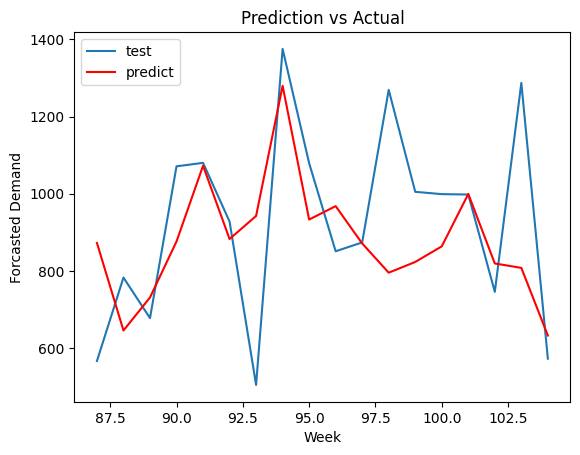

In [18]:
plt.plot(test['units_sold_sum'], label = 'test')
plt.plot(pred_test, color = 'red', label = 'predict')
plt.xlabel('Week')
plt.ylabel('Forcasted Demand')
plt.title('Prediction vs Actual')
plt.legend()
plt.show()

# Model Saving

In [20]:
with open("model.pkl", "wb") as f:
    pickle.dump(result_model_sar1, f)

# Inference Test